In [22]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from joblib import load
import tensorflow
import os


In [20]:
model = XGBClassifier()
model.load_model(r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_model.json")
scaler = load(r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_scaler.pkl")

print("Models loaded successfully.")  


Models loaded successfully.


In [24]:
# --- 2. Load Combined Clean Dataset ---
data_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE\CICIDS2017_clean_binary.csv"
df = pd.read_csv(data_path)
print(f"Loaded dataset: {df.shape}")

# --- Autoencoder-based reconstruction error (for hybrid model) ---
if "reconstruction_error" not in df.columns:
    print("⚙️ Computing reconstruction_error using trained autoencoder...")
    from tensorflow.keras.models import load_model

    auto_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\autoencoder_model.keras"
    if os.path.exists(auto_path):
        autoencoder = load_model(auto_path)
        print("✅ Loaded trained autoencoder model.")

        # Keep only numeric features for encoding
        df_features = df.drop(columns=["Label"], errors="ignore").select_dtypes(include=[np.number])

        # Scale features using the same scaler
        df_scaled = scaler.transform(df_features)

        # Compute reconstruction error per sample
        reconstructions = autoencoder.predict(df_scaled, verbose=0)
        reconstruction_error = np.mean(np.square(df_scaled - reconstructions), axis=1)

        # Append as new feature
        df["reconstruction_error"] = reconstruction_error
        print(f"✅ Added reconstruction_error column. New shape: {df.shape}")
    else:
        raise FileNotFoundError(
            f"❌ Autoencoder model not found at {auto_path}. Please ensure it’s saved before hybrid inference."
        )
else:
    print("✅ reconstruction_error already present in dataset.")

Loaded dataset: (2604998, 79)
⚙️ Computing reconstruction_error using trained autoencoder...
✅ Loaded trained autoencoder model.
✅ Added reconstruction_error column. New shape: (2604998, 80)


In [25]:

X_scaled = scaler.transform(X)
booster_features = model.get_booster().feature_names

# Align feature count to scaled data shape
if booster_features and len(booster_features) != X_scaled.shape[1]:
    print(f"⚠️ Feature count mismatch: model={len(booster_features)} vs data={X_scaled.shape[1]}")
    booster_features = booster_features[:X_scaled.shape[1]]

X_scaled_df = pd.DataFrame(X_scaled, columns=booster_features)
print(f"✅ Created aligned DataFrame with {X_scaled_df.shape[1]} features.")



# --- 5. Model Predictions ---
y_pred = model.predict(X_scaled_df)
y_proba = model.predict_proba(X_scaled_df)[:, 1]

print(f"Accuracy: {(y_pred == y).mean():.4f}")
print(f"ROC-AUC: {roc_auc_score(y, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y, y_pred))

⚠️ Feature count mismatch: model=79 vs data=78
✅ Created aligned DataFrame with 78 features.


ValueError: feature_names mismatch: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'reconstruction_error'] ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']
expected reconstruction_error in input data

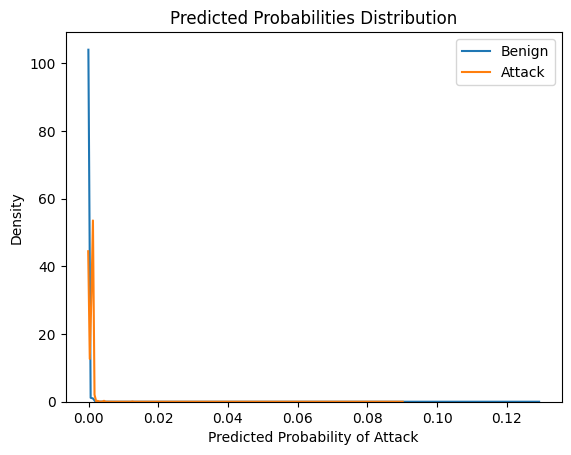

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(y_proba[y == 0], label='Benign')
sns.kdeplot(y_proba[y == 1], label='Attack')
plt.title('Predicted Probabilities Distribution')
plt.xlabel('Predicted Probability of Attack')
plt.legend()
plt.show()
